# Classifying hate speech tweets
## Using Multi-variate Bernoulli Naive Bayes and Multinominal Naive Bayes in combination with count vectorizer and TF-IDF vectorizer

### To Do's/ Ideas
- Remove 'user' string as it doesnt contain information and possibly negatively affects performance as Naive Bayes has problems with too many redundant attributes
- Modify Preprocessing (currently default count and TF-IDF vectroizer preprocessing used)
    - Implement Emoji transformation
    - Implement Morphological Normalization (e.g. Stemming)
    - Currently stop words are only removed in one scenario

In [1]:
import numpy as np
import pandas as pd
import sklearn.model_selection as ms
import sklearn.feature_extraction.text as text
import sklearn.naive_bayes as nb
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [2]:
from string import punctuation
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

In [3]:
from datasets import load_dataset

dataset = load_dataset("tweets_hate_speech_detection")

E:\Programme\Miniconda\envs\DataMining\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using custom data configuration default
Reusing dataset tweets_hate_speech_detection (C:\Users\jonas\.cache\huggingface\datasets\tweets_hate_speech_detection\default\0.0.0\c6b6f41e91ac9113e1c032c5ecf7a49b4e1e9dc8699ded3c2d8425c9217568b2)
100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.59it/s]


In [4]:
df = pd.DataFrame.from_dict(dataset['train'])
df.head()

,label,tweet
0,0,@user when a father is dysfunctional and is so...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation


In [5]:
# Currently not in use
'''def remove_punctioation(text:str) -> str:
    return "".join([i for i in text if i not in punctuation])

def tokenization(text:str) -> list:
    return nltk.word_tokenize(text)

def remove_stopwords(tokens) ->list:
    stopwords_list = stopwords.words("english")
    return [token for token in tokens if token not in stopwords_list]

porter_stemmer = PorterStemmer()

def stemming(text:list) -> list:
    return [porter_stemmer.stem(word) for word in text]''';

In [6]:
# Currently not in use
'''df["preprocessed"] = df["tweet"].apply(lambda x: stemming(tokenization(remove_punctioation(x.lower()))))''';

In [7]:
df.head()

,label,tweet
0,0,@user when a father is dysfunctional and is so...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation


# Model Building

In [8]:
# Definition des Label-Vektors
y = df['label']

## Using TF-IDF Vectorizer

In [9]:
# Definition der Feature-Matrix
tf = text.TfidfVectorizer()

X_vec = tf.fit(df['tweet'])
X = X_vec.transform(df['tweet'])

print(X.shape)

(31962, 41392)


### Splitting Data into train and test data

In [10]:
# Splitting of data into training and test data
from sklearn.model_selection import train_test_split
(X_train, X_test, y_train, y_test) = ms.train_test_split(X, y, test_size=0.2, random_state = 17, stratify=y)

In [11]:
# Testing Stratification
print('There is {} training data, of which {}% is hate speech '.format(y_train.count(), round(y_train.sum()/y_train.count()*100,2)))
print('There is {} test data, of which {}% is hate speech '.format(y_test.count(), round(y_test.sum()/y_test.count()*100,2)))

There is 25569 training data, of which 7.02% is hate speech 
There is 6393 test data, of which 7.01% is hate speech 


### Train Models
The method GridSearchCV is used for hyperparameter optimization. In the following cases the smoothing parameter alpha is optimized.

In [15]:
# Multi-variate Bernoulli Naive Bayes
bnb = ms.GridSearchCV(nb.BernoulliNB(), param_grid={'alpha':np.logspace(-2., 2., 50)})
bnb.fit(X_train, y_train);

# Multinominal Naive Bayes
mnb = ms.GridSearchCV(nb.MultinomialNB(), param_grid={'alpha':np.logspace(-2., 2., 50)})
mnb.fit(X_train, y_train);

### Evaluate Model Performance based on TF-IDF Vectorizer

In [16]:
print(f'The hit rate with the multi-variate Bernoulli Naive Bayes is approx. {round(100*bnb.score(X_test, y_test),2)}%')
print('Precision: %.3f' % precision_score(y_test, bnb.predict(X_test)))
print('Recall: %.3f' % recall_score(y_test, bnb.predict(X_test)))
print('Accuracy: %.3f' % accuracy_score(y_test, bnb.predict(X_test)))
print('F1 Score: %.3f' % f1_score(y_test, bnb.predict(X_test)))

The hit rate with the multi-variate Bernoulli Naive Bayes is approx. 95.1%
Precision: 0.713
Recall: 0.504
Accuracy: 0.951
F1 Score: 0.591


In [18]:
print(f'The hit rate with the Multinominal Naive Bayes is approx. {round(100*mnb.score(X_test, y_test),2)}%')
print('Precision: %.3f' % precision_score(y_test, mnb.predict(X_test)))
print('Recall: %.3f' % recall_score(y_test, mnb.predict(X_test)))
print('Accuracy: %.3f' % accuracy_score(y_test, mnb.predict(X_test)))
print('F1 Score: %.3f' % f1_score(y_test, mnb.predict(X_test)))

The hit rate with the Multinominal Naive Bayes is approx. 94.79%
Precision: 0.715
Recall: 0.426
Accuracy: 0.948
F1 Score: 0.534


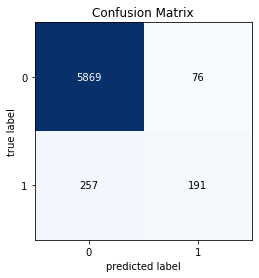

In [19]:
# Confusion-Matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, mnb.predict(X_test))

from mlxtend.plotting import plot_confusion_matrix

fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.title("Confusion Matrix")
plt.show()

# Using Count Vectorizer

In [20]:
co = text.CountVectorizer()

Xc_vec = co.fit(df['tweet'])
Xc = Xc_vec.transform(df['tweet'])

print(Xc.shape)

(31962, 41392)


### Split Data

In [21]:
# Splitting of data into training and test data
(Xc_train, Xc_test, yc_train, yc_test) = ms.train_test_split(Xc, y, test_size=.2, random_state = 17)

### Train Models

In [22]:
# Multi-variate Bernoulli Naive Bayes
bnbc = ms.GridSearchCV(nb.BernoulliNB(), param_grid={'alpha':np.logspace(-2., 2., 50)})
bnbc.fit(Xc_train, yc_train);


# Multinominal Naive Bayes
mnbc = ms.GridSearchCV(nb.MultinomialNB(), param_grid={'alpha':np.logspace(-2., 2., 50)})
mnbc.fit(Xc_train, yc_train);

### Evaluate Model Performance based on Count Vectorizer

In [23]:
print(f'The hit rate with the multi-variate Bernoulli Naive Bayes is approx. {round(100*bnbc.score(Xc_test, yc_test),2)}%')
print('Precision: %.3f' % precision_score(yc_test, bnbc.predict(Xc_test)))
print('Recall: %.3f' % recall_score(yc_test, bnbc.predict(Xc_test)))
print('Accuracy: %.3f' % accuracy_score(yc_test, bnbc.predict(Xc_test)))
print('F1 Score: %.3f' % f1_score(yc_test, bnbc.predict(Xc_test)))

The hit rate with the multi-variate Bernoulli Naive Bayes is approx. 95.21%
Precision: 0.689
Recall: 0.519
Accuracy: 0.952
F1 Score: 0.592


In [24]:
print(f'The hit rate with the Multinominal Naive Bayes is approx. {round(100*mnbc.score(Xc_test, yc_test),2)}%')
print('Precision: %.3f' % precision_score(yc_test, mnbc.predict(Xc_test)))
print('Recall: %.3f' % recall_score(yc_test, mnbc.predict(Xc_test)))
print('Accuracy: %.3f' % accuracy_score(yc_test, mnbc.predict(Xc_test)))
print('F1 Score: %.3f' % f1_score(yc_test, mnbc.predict(Xc_test)))

The hit rate with the Multinominal Naive Bayes is approx. 94.1%
Precision: 0.560
Recall: 0.556
Accuracy: 0.941
F1 Score: 0.558


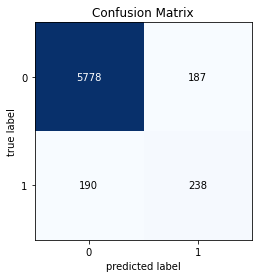

In [25]:
# Confusion-Matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(yc_test, mnbc.predict(Xc_test))

from mlxtend.plotting import plot_confusion_matrix

fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.title("Confusion Matrix")
plt.show()

# Analyze frequent words

In [26]:
# Get most frequent words including stop words
word_freq_df = pd.DataFrame(Xc.toarray(), columns=co.get_feature_names_out())
top_words_df = pd.DataFrame(word_freq_df.sum()).sort_values(0, ascending=False)
top_words_df.head(10)

,0
user,17577
the,10193
to,9849
you,5908
and,4920
in,4660
for,4497
of,4239
is,4187
my,3703


In [27]:
# Remove Stopwords
co = text.CountVectorizer(stop_words='english')

Xc_vec = co.fit(df['tweet'])
Xc = Xc_vec.transform(df['tweet'])

print(Xc.shape)

(31962, 41104)


In [28]:
# Get most frequent words excluding stop words
word_freq_df_sw = pd.DataFrame(Xc.toarray(), columns=co.get_feature_names_out())
top_words_df_sw = pd.DataFrame(word_freq_df_sw.sum()).sort_values(0, ascending=False)
top_words_df_sw.head(10)

,0
user,17577
love,2749
day,2311
amp,1776
happy,1686
just,1365
time,1136
life,1131
today,1079
like,1050


### Train MN Naive Baies Model using Count Vectorizer excluding Stopwords 

In [29]:
# Splitting of data into training and test data
(Xc_train, Xc_test, yc_train, yc_test) = ms.train_test_split(Xc, y, test_size=.2, random_state = 17)

In [30]:
# Multinominal Naive Bayes
mnbc = nb.MultinomialNB()
mnbc.fit(Xc_train, yc_train);
yc_pred = mnbc.predict(Xc_test)

In [31]:
print(f'The hit rate with the Multinominal Naive Bayes is approx. {round(100*mnbc.score(Xc_test, yc_test),2)}%')
print('Precision: %.3f' % precision_score(yc_test, yc_pred))
print('Recall: %.3f' % recall_score(yc_test, yc_pred))
print('Accuracy: %.3f' % accuracy_score(yc_test, yc_pred))
print('F1 Score: %.3f' % f1_score(yc_test, yc_pred))

The hit rate with the Multinominal Naive Bayes is approx. 94.37%
Precision: 0.575
Recall: 0.610
Accuracy: 0.944
F1 Score: 0.592


## Get words with biggest impact on each category

In [32]:
# Get words with biggest impact on each category

mnbc.feature_log_prob_
mnbc.coef_

feature_names = co.get_feature_names_out()
for i, class_label in enumerate(['no_hate', 'hate']):
    top10 = np.argsort(mnbc.feature_log_prob_[i])[-10:]
    print("%s: %s" % (class_label,
          " ".join(feature_names[j] for j in top10)))

no_hate: thankful today life time just amp happy day love user
hate: people politics racist black like libtard white trump amp user


E:\Programme\Miniconda\envs\DataMining\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: Attribute `coef_` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)
